<a href="https://colab.research.google.com/github/FelipeSotoG/U-Net-ResNetBlocks/blob/main/Attention_Resnet_Multihead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Descarga datos
Los datos se encuentran en el drive, por lo que usara gdown para sacarlos directamente y no tener que hacer la coneccion, ya que estamos descargando un zip.

In [43]:
!gdown https://drive.google.com/uc?id=1f3hc0IdnyN60NjGoPO9Za9Vnmj9pk3zt

Downloading...
From: https://drive.google.com/uc?id=1f3hc0IdnyN60NjGoPO9Za9Vnmj9pk3zt
To: /content/input.zip
100% 597M/597M [00:06<00:00, 88.8MB/s]


In [44]:
!unzip -q input.zip

replace input/train/masks/radiopaedia_10_85902_3_397.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [45]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [46]:
import nibabel as nib
import os
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
import cv2
import torch

In [47]:
import imageio as iio
import glob
from skimage.transform import resize
src="/content/input/train"
imag="/images/"
X=np.zeros((len(glob.glob(src+imag+"*.png")),IMG_WIDTH,IMG_HEIGHT,1))
for i,x in enumerate(sorted(glob.glob(src+imag+"*.png"))):
  X[i]=resize(iio.imread(x),(IMG_WIDTH,IMG_HEIGHT,1),mode="constant",preserve_range=True)
mas="/masks/"
Y=np.zeros((len(glob.glob(src+mas+"*.png")),IMG_WIDTH,IMG_HEIGHT,1))
for i,x in enumerate(sorted(glob.glob(src+mas+"*.png"))):
  Y[i]=resize(iio.imread(x),(IMG_WIDTH,IMG_HEIGHT,1),mode="constant",preserve_range=True)/255

##Borrar directorio /input en caso de error

In [ ]:
!rm -r /content/input

##Train Test Split

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=2)

##Resnet

In [49]:
from keras.layers import Layer
import keras.backend as K
import torch.nn as nn

In [50]:
def DiceMetric(y_true, y_pred):
  smooth=1e-6 
  gama=2
  y_true, y_pred = tf.cast(
      y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
  nominator = 2 * \
      tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
  denominator = tf.reduce_sum(
      y_pred ** gama) + tf.reduce_sum(y_true ** gama) + smooth
  result = tf.divide(nominator, denominator)
  return result
def DiceLoss(y_true, y_pred):
      result= 1- DiceMetric(y_true, y_pred)
      return result

In [51]:
def conv_block(X,f,d=0.1,group=1):
  c = tf.keras.layers.Conv2D(f[0], (2, 2), activation='relu', kernel_initializer='he_normal', padding='same',groups=group)(X)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  c = tf.keras.layers.Conv2D(f[1], (2, 2), kernel_initializer='he_normal', padding='same', groups=group)(c)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  s = tf.keras.layers.Conv2D(f[1], (2, 2), kernel_initializer='he_normal', padding='same')(X)
  s = tf.keras.layers.BatchNormalization(axis=3)(s)
  c = tf.keras.layers.Add()([c,s])
  c = tf.keras.layers.ReLU()(c)
  return c,s

### Max pooling

In [52]:
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
nheads=32

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#s= inputs
#Contraction path
c1,z1 = conv_block(s,[16,16])
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


c2,z2 = conv_block(p1,[32,32])
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3,z3 = conv_block(p2,[64,64],0.2)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4,z4 = conv_block(p3,[128,128],0.2)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5,z5 = conv_block(p4,[256,256],0.3)

#Expansive path 
z5=tf.keras.layers.MaxPooling2D((4, 4))(z5)
m1= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z4,z5)
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, m1])
c6,z6 = conv_block(u6,[128,128],0.2)

z6=tf.keras.layers.MaxPooling2D((4, 4))(z6)
m2= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z3,z6)
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, m2])
c7,z7 = conv_block(u7,[64,64],0.2)

z7=tf.keras.layers.MaxPooling2D((4, 4))(z7)
m3= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z2,z7) 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, m3])
c8,z8 = conv_block(u8,[32,32])

z8=tf.keras.layers.MaxPooling2D((4, 4))(z8)
m4= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z1,z8) 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, m4], axis=3)
c9,_ = conv_block(u9,[16,16])
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_11 (Lambda)             (None, 128, 128, 1)  0           ['input_12[0][0]']               
                                                                                                  
 conv2d_282 (Conv2D)            (None, 128, 128, 16  80          ['lambda_11[0][0]']              
                                )                                                                 
                                                                                           

### Average pooling

In [53]:
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
nheads=16

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#s= inputs
#Contraction path
c1,z1 = conv_block(s,[16,16])
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


c2,z2 = conv_block(p1,[32,32])
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3,z3 = conv_block(p2,[64,64],0.2)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4,z4 = conv_block(p3,[128,128],0.2)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5,z5 = conv_block(p4,[256,256],0.3)

#Expansive path 
z5=tf.keras.layers.AveragePooling2D(strides=(3,3))(z5)
m1= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z4,z5)
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, m1])
c6,z6 = conv_block(u6,[128,128],0.2)

z6=tf.keras.layers.AveragePooling2D(strides=(3,3))(z6)
m2= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z3,z6)
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, m2])
c7,z7 = conv_block(u7,[64,64],0.2)

z7=tf.keras.layers.AveragePooling2D(strides=(3,3))(z7)
m3= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z2,z7) 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, m3])
c8,z8 = conv_block(u8,[32,32])

z8=tf.keras.layers.AveragePooling2D(strides=(5,5))(z8)
m4= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z1,z8) 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, m4], axis=3)
c9,_ = conv_block(u9,[16,16])
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_12 (Lambda)             (None, 128, 128, 1)  0           ['input_13[0][0]']               
                                                                                                  
 conv2d_310 (Conv2D)            (None, 128, 128, 16  80          ['lambda_12[0][0]']              
                                )                                                                 
                                                                                           

##Model Fit

In [ ]:
model.fit(X_train,Y_train,batch_size=10,epochs=25,validation_split=0.2)

Epoch 1/25
198/198 [==============================] - 57s 286ms/step - loss: 0.0236 - accuracy: 0.9882 - DiceMetric: 0.6715 - val_loss: 0.0234 - val_accuracy: 0.9871 - val_DiceMetric: 0.4584
Epoch 2/25
198/198 [==============================] - 52s 262ms/step - loss: 0.0170 - accuracy: 0.9885 - DiceMetric: 0.7510 - val_loss: 0.0170 - val_accuracy: 0.9875 - val_DiceMetric: 0.6516
Epoch 3/25
198/198 [==============================] - 52s 262ms/step - loss: 0.0146 - accuracy: 0.9886 - DiceMetric: 0.7812 - val_loss: 0.0148 - val_accuracy: 0.9872 - val_DiceMetric: 0.7392
Epoch 4/25
198/198 [==============================] - 52s 262ms/step - loss: 0.0152 - accuracy: 0.9883 - DiceMetric: 0.7446 - val_loss: 0.0146 - val_accuracy: 0.9874 - val_DiceMetric: 0.7117
Epoch 5/25
198/198 [==============================] - 52s 262ms/step - loss: 0.0119 - accuracy: 0.9888 - DiceMetric: 0.8197 - val_loss: 0.0139 - val_accuracy: 0.9870 - val_DiceMetric: 0.7869
Epoch 6/25
198/198 [=========================

In [54]:
model.fit(X_train,Y_train,batch_size=10,epochs=200,validation_split=0.2)

Epoch 1/200
198/198 [==============================] - 58s 267ms/step - loss: 0.1938 - accuracy: 0.9530 - DiceMetric: 0.0627 - val_loss: 0.0792 - val_accuracy: 0.9855 - val_DiceMetric: 0.0761
Epoch 2/200
198/198 [==============================] - 52s 263ms/step - loss: 0.0593 - accuracy: 0.9870 - DiceMetric: 0.0651 - val_loss: 0.0601 - val_accuracy: 0.9855 - val_DiceMetric: 0.0582
Epoch 3/200
198/198 [==============================] - 52s 262ms/step - loss: 0.0438 - accuracy: 0.9870 - DiceMetric: 0.1716 - val_loss: 0.0495 - val_accuracy: 0.9855 - val_DiceMetric: 0.3111
Epoch 4/200
198/198 [==============================] - 52s 262ms/step - loss: 0.0341 - accuracy: 0.9869 - DiceMetric: 0.2973 - val_loss: 0.0444 - val_accuracy: 0.9855 - val_DiceMetric: 0.1117
Epoch 5/200
198/198 [==============================] - 52s 262ms/step - loss: 0.0272 - accuracy: 0.9869 - DiceMetric: 0.4443 - val_loss: 0.0233 - val_accuracy: 0.9861 - val_DiceMetric: 0.5072
Epoch 6/200
198/198 [===================

In [55]:
scores= model.evaluate(X_test, Y_test, verbose=0)
print(f'Score for fold {0}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
print(model.metrics_names)

Score for fold 0: loss of 0.007697664201259613; accuracy of 98.96839261054993% DiceMetric of 92.16498136520386%
['loss', 'accuracy', 'DiceMetric']


In [ ]:
print(model.metrics_names)

##Testing

In [56]:
Ypred=model.predict(X_test)

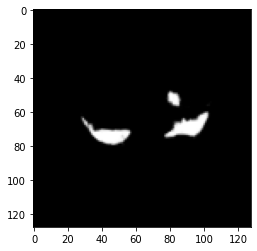

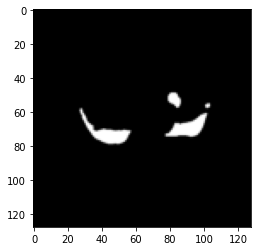

In [57]:
plt.imshow(np.reshape(Ypred[160],(128,128)), cmap=plt.cm.gray)
plt.show()
plt.imshow(np.reshape(Y_test[160],(128,128)), cmap=plt.cm.gray)
plt.show()

In [ ]:
def dice(true_mask, pred_mask):
    """
        Computes the Dice coefficient.
        Args:
            true_mask : Array of arbitrary shape.
            pred_mask : Array with the same shape than true_mask.  
        
        Returns:
            A scalar representing the Dice coefficient between the two segmentations. 
        
    """
    non_seg_score=1.0
    if type(pred_mask) != np.ndarray:
      t = torch.Tensor([0.5])
      pred_mask=(pred_mask > t)
    else:
      pred_mask[pred_mask>=0.5]=1
      pred_mask[pred_mask<0.5]=0

    # If both segmentations are all zero, the dice will be 1. (Developer decision)
    im_sum = true_mask.sum() + pred_mask.sum()
    if im_sum == 0:
        return non_seg_score

    # Compute Dice coefficient
    intersection = np.logical_and(true_mask, pred_mask)
    return 2. * intersection.sum() / im_sum

In [ ]:
diceaux=dice(Y_test[160],Ypred[160])
diceaux

0.9357399154707194

## Model Fit Kfold

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd

In [ ]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

25 epochs

In [ ]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
nfold=1
for train_index, val_index in cv.split(X,Y):
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])

  X_fold=X[train_index,:,:]
  Y_fold=Y[train_index,:,:]
  
  model.fit(X_fold,Y_fold,batch_size=16,epochs=25,validation_split=0.2,verbose=0)

  Xtest_fold=X[val_index,:,:]
  Ytest_fold=Y[val_index,:,:]
  scores= model.evaluate(Xtest_fold, Ytest_fold, verbose=0)
  print(f'Score for fold {nfold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
  nfold+=1

Score for fold 1: loss of 0.010589624755084515; accuracy of 98.96852374076843% DiceMetric of 90.11987447738647%
Score for fold 2: loss of 0.017074687406420708; accuracy of 98.8399863243103% DiceMetric of 88.72661590576172%
Score for fold 3: loss of 0.019004367291927338; accuracy of 98.89352321624756% DiceMetric of 85.86874604225159%
Score for fold 4: loss of 0.021750498563051224; accuracy of 98.8770842552185% DiceMetric of 87.11013793945312%
Score for fold 5: loss of 0.02564629353582859; accuracy of 98.92171621322632% DiceMetric of 84.32435989379883%


50 epochs

In [42]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
nfold=1
for train_index, val_index in cv.split(X,Y):
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])

  X_fold=X[train_index,:,:]
  Y_fold=Y[train_index,:,:]
  
  model.fit(X_fold,Y_fold,batch_size=16,epochs=50,validation_split=0.2,verbose=0)

  Xtest_fold=X[val_index,:,:]
  Ytest_fold=Y[val_index,:,:]
  scores= model.evaluate(Xtest_fold, Ytest_fold, verbose=0)
  print(f'Score for fold {nfold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
  nfold+=1

Score for fold 1: loss of 0.016142617911100388; accuracy of 98.95281195640564% DiceMetric of 86.89823746681213%
Score for fold 2: loss of 0.02502174861729145; accuracy of 98.81399273872375% DiceMetric of 86.29720211029053%
Score for fold 3: loss of 0.029437260702252388; accuracy of 98.87399077415466% DiceMetric of 82.6685905456543%
Score for fold 4: loss of 0.027194472029805183; accuracy of 98.87163639068604% DiceMetric of 86.16846203804016%
Score for fold 5: loss of 0.029874801635742188; accuracy of 98.91415238380432% DiceMetric of 83.36634039878845%
